In [49]:
# Для корректной работы ноутбука необходимо установить универсальную среду для запуска решателей minizinc
# Это необходимо для решения задач линейного программирования, описанных в файлах mzn

# Описание на wikipedia
# https://en.wikipedia.org/wiki/MiniZinc

# Документация по установке
# https://docs.minizinc.dev/en/stable/installation.html

# Скачать можно на странице по адресу:
# https://www.minizinc.org/

# Указать путь к minizinc.exe
minizinc_exec_path = "Q:/_APPS/MiniZinc/minizinc.exe"

# Путь к данным решателя по умолчанию
# Для увеличения скорости можно записывать файл в tmpfs или ramdisk (в оперативную память)
# По умолчанию данные для модели записываются в одну директорию с моделью и ноутбуком
default_minizinc_data_path = "./data.dzn"

# Путь к экземплярам тестов и результам их вычисления
# Директория, где расположены json'ы, txt и csv файлы
default_problem_instances_path = "./data"

# Тесты должны лежать в архиве "data.zip".
# Необходимо распаковать "data.zip" в папку "./data"

In [4]:
import os
import csv
import math
import copy
import json
import time
import numpy as np
import random
import hashlib
import itertools
import subprocess

from munkres import Munkres, print_matrix
from functools import cmp_to_key
from collections import defaultdict
from scipy.optimize import linear_sum_assignment

from tqdm.notebook import trange, tqdm
from IPython.display import clear_output

In [5]:
# enumerate, который производит итерацию начиная с последнего элемента в списке
def reversed_enumerate(arr: list):
    for i in range(len(arr) - 1, -1, -1):
        yield i, arr[i]

In [6]:
# Округление всей матрицы
def deep_round(val, prec=0):
    if not hasattr(val, '__iter__'):
        return round(val, prec)
    for i, _ in enumerate(val):
        val[i] = deep_round(val[i], prec)
    return val

In [7]:
# Вернуть значение свойства сложного объекта по указанному пути
def nget(obj, path, defval=None):
    for k in path:
        if obj is None:
            return defval
        elif hasattr(obj, 'get'):
            if k not in obj:
                return defval
            obj = obj.get(k)
        elif hasattr(obj, '__iter__'):
            if type(k) != int:
                return defval
            elif len(obj) - 1 < k:
                return defval
            else:
                obj = obj[k]
        else:
            return defval
    return obj

In [8]:
# 
# Матричное представление задачи
# Рассчитать и вернуть матрицу взвешенного времени (матрицу стоимостей)
# 
def create_cost_matrix(p, w, r, s1, s2, d1, d2):
    # p:  list = PROC_TIMES     = Количество задач в работах
    # w:  list = WEIGHTS        = Веса
    # r:  list = RELEASE_DATES  = Время старта работы
    # s1: list = EARLY_S_DATES  = Время опережения запуска работы
    # s2: list = DUE_S_DATES    = Время запаздывания запуска работы
    # d1: list = EARLY_C_DATES  = Время опережения завершения работы
    # d2: list = DUE_C_DATES    = Время запаздывания завершения работы

    n    = len(w) # количество работ
    T    = sum(p) # временной горизонт
    _inf = max((T*max(w))**2, 1000) # достаточно большое число (выполняет роль бесконечности)

    # результат, матрица взвешенного времени
    # инициализировать с нулями
    cost = []

    for j in range(n):
        job = []
        
        for k in range(p[j]):
            oper = []
            _k = k + 1  # индекс работы начиная от 1 (в соотв. с описанием в задаче ЛП)
            
            for t in range(T):
                _t = t + 1  # время начиная от 1 (в соотв. с описанием в задаче ЛП)
                
                # w_jpt = последняя операция в работе
                if _k == p[j]:
                    if r[j] + p[j] - 1 <= _t:
                        w_jkt = w[j] * (  max(0, _t - d2[j]) + max(0, d1[j] - _t)  )
                    else:
                        w_jkt = _inf
                        
                # w_j1t = первая операция в работе
                elif _k == 1:
                    if r[j] <= _t and _t <= T - p[j] + 1:
                        w_jkt = w[j] * (  max(0, _t - s2[j]) + max(0, s1[j] - _t)  )
                    else:
                        w_jkt = _inf
                        
                # w_jkt = все остальные операции
                else:
                    if r[j] + _k - 1 <= _t and _t <= T - p[j] + _k:
                        w_jkt = 0
                    else:
                        w_jkt = _inf
                        
                oper.append(w_jkt)
            # end for t
            job.append(oper)
        # end for k
        cost.append(job)
    # end for j

    return cost

In [9]:
# Вернуть тестовые параметры. Пример из диплома
def get_test_case_1_params():
    return {
        "p" : [3,2,5], "w" : [1,3,5], "r": [1,3,4],
        "s1": [1,3,4], "s2": [3,3,4],
        "d1": [4,6,9], "d2": [4,6,9],
    }

# Вернуть параметры example 2. Из "HOCO Scheduling Final 08.07.2024.pdf"
def get_test_case_2_params():
    return {
        "r": [1,  4,  3,  2],
        "w": [4,  9, 12,  9],
        "p": [2,  2,  2,  2],
    }

In [10]:
# Рассчитать и вернуть значение целевой функции из решения
# Матричное решение
def calc_obj_from_mat(w, x):
    # w = матрица взвешенного времени
    # x = матрица решения
    # Сумма по всем элементам матрицы произведения Адамара (w * x)
    if not hasattr(w, '__iter__'):
        return w * x
    _sum = 0
    for i, _ in enumerate(w):
        _sum += calc_obj_from_mat(w[i], x[i])
    return _sum

# Рассчитать и вернуть значение целевой функции из решения
# Векторное решение. К примеру эвристики
def calc_obj_from_vec(w, v):
    _sum = 0
    ktable = [0] * len(w)
    for t, j in enumerate(v):
        if j < 0: continue
        j = j - 1
        k = ktable[j]
        _sum += w[j][k][t]
        ktable[j] += 1
    return _sum

In [11]:
# Вернуть расписание как вектор
def get_schedule_vec(x):
    # x: list[j,k,t] = расписание как матрица
    vec = [0] * len(x[0][0])
    for j, _ in enumerate(x):
        for k, _ in enumerate(x[j]):
            for t, _ in enumerate(x[j][k]):
                if x[j][k][t]:
                    vec[t] = j + 1
    return vec      

In [12]:
# Проверить порядок операций в работах.
# O(n*T)
def is_valid_schedule_order(x):
    # x: list[j,k,t] = решение

    for j, _ in enumerate(x):
        c1 = 0
        prev_t = 0
        for k, _ in enumerate(x[j]):
            T = len(x[j][k])
            for t in range(prev_t, T):
                x_jkt = round(x[j][k][t], 10)
                if 0 < x_jkt and x_jkt < 1:
                    return False
                if x_jkt:
                    c1 += 1
                    prev_t = t + 1
                    break
                if T - 1 == t:
                    return False
        if c1 != len(x[j]):
            return False
    return True

# ----------------------------
# Тестовый пример p = [2,1,3]
# ----------------------------
# is_valid_schedule_order([
#    [[1, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 1, 0]],
    
#    [[0, 0, 1, 0, 0, 0]],
    
#    [[0, 1, 0, 0, 0, 0],
#     [0, 0, 0, 1, 0, 0],
#     [0, 0, 0, 0, 0, 1]],
# ])

In [13]:
# Вернуть время, в которое выполняется каждая работа
def get_job_time_slots(s):
    # s: list = расписание
    job_times = defaultdict(list)
    for t, j in enumerate(s, start=1):
        job_times[j].append(t)
    return job_times

# Проверить прерывает ли работа j2 работу j1
def is_job_intersects(j2, j1, job_times):
    # j1: int = номер прерываемой работы
    # j2: int = номер прерывающей работы
    # job_times: get_job_time_slots()
    if not job_times[j1] or not job_times[j2]:
        return False
    start = job_times[j1][0]
    compl = job_times[j1][-1]
    for t in job_times[j2]:
        if start < t < compl:
            return True
    return False

# Проверить наличие взаимных прерываний
def has_mutual_job_intersection(s, job_times=None):
    # s: list = расписание
    # job_times: get_job_time_slots()
    if not job_times:
        job_times = get_job_time_slots(s)
    for j1, j2 in itertools.combinations(job_times.keys(), 2):
        if (
                is_job_intersects(j2, j1, job_times)
            and is_job_intersects(j1, j2, job_times)
        ):
            return True
    return False

# Проверить выполняется ли работа вовремя: вовремя запускается и вовремя завершается
def is_job_processed_intime(j, params, job_times):
    # j: int = номер работы
    # params: object = параметры работ
    # job_times: get_job_time_slots()
    if not job_times:
        return False
    start = job_times[j][0]
    compl = job_times[j][-1]
    h = j - 1
    if (
            (params["s1"][h] <= start <= params["s2"][h])
        and (params["d1"][h] <= compl <= params["d2"][h])
    ):
        return True
    return False

# Проверить выполняемость вовремя работ. Вернуть список [True, False, ...]
def get_processed_intime_jobs(s, params, job_times=None):
    # s: list = расписание
    # params: object = параметры работ
    # job_times: get_job_time_slots()
    if not job_times:
        job_times = get_job_time_slots(s)
    jobs = sorted(job_times.keys(), reverse=False)
    return [
        is_job_processed_intime(j, params, job_times)
        for j in jobs
    ]

# ----------------------------
# Тест
# ----------------------------
def main():
    test_cases = [
        { "s1": [1, 7, 4], "s2": [ 3,  9,  5], "d1": [3, 10, 7],  "d2": [ 3, 10, 10] },    # -> 1,1,1
        { "s1": [1, 1, 1], "s2": [10, 10, 10], "d1": [1,  1, 1],  "d2": [10, 10, 10] },    # -> 1,1,1
        { "s1": [1, 1, 1], "s2": [10, 10, 10], "d1": [1,  1, 4],  "d2": [10, 10,  7] },    # -> 1,1,0
        { "s1": [2, 1, 1], "s2": [ 3, 10, 10], "d1": [1,  1, 1],  "d2": [10,  8, 10] },    # -> 0,0,1
    ]

    #                1  2  3  4  5  6  7  8  9  10
    test_schedule = [1, 1, 1, 3, 3, 3, 3, 3, 2, 2]
    
    for i, params in enumerate(test_cases, 1):
        print(i, get_processed_intime_jobs(test_schedule, params))
main()

# ----------------------------
# Тест
# ----------------------------
def main():
    test_cases = [
        [1, 1, 1, 3, 3, 3, 3, 3, 2, 2],    # Без прерываний
        [1, 1, 2, 3, 1, 2, 3, 3, 3, 3],    # Взаимное прерывание двух работ
        [1, 1, 1, 3, 3, 2, 2, 3, 3, 3],    # Одна работа прерывает другую
    ]
    
    for i, s in enumerate(test_cases, 1):
        print(s, has_mutual_job_intersection(s))
main()

1 [True, True, True]
2 [True, True, True]
3 [True, True, False]
4 [False, False, True]
[1, 1, 1, 3, 3, 3, 3, 3, 2, 2] False
[1, 1, 2, 3, 1, 2, 3, 3, 3, 3] True
[1, 1, 1, 3, 3, 2, 2, 3, 3, 3] False


In [14]:
# Решить задачу о назначениях
# Венгерский алгоритм
# Также известный как Kuhn–Munkres algorithm или Munkres assignment algorithm
# https://en.wikipedia.org/wiki/Hungarian_algorithm

munk = Munkres()
def solve_lap(_w):
    # _w: list[T,T] = матрица взвешенного времени

    w = _w.copy()
    indexes = munk.compute(w)
    n = len(w)
    m = len(w[0])
    x = [[0] * m for i in range(n)]
    for i,j in indexes:
        x[i][j] = 1
    return x

In [15]:
# Решить задачу о назначениях
# Алгоритм двумерных прямоугольников из пакета scipy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
# https://ieeexplore.ieee.org/document/7738348
# Решение будет оптимальным, но может отличаться от венгерского

def solve_lap2(w):
    # w: list[T,T] = матрица взвешенного времени
    
    sol_index_x, sol_index_y = linear_sum_assignment(w)
    n, m = len(sol_index_x), len(sol_index_y)
    x = [[0] * m for i in range(n)]
    for k, _ in enumerate(sol_index_x):
        i = sol_index_x[k]
        j = sol_index_y[k]
        x[i][j] = 1
    return x

In [16]:
# 
# Подготовить и вернуть данные для решателя
# 
def create_solver_data_str(w):
    # w: list[j,k,t] = матрица взвешенного времени

    _inf   = w[0][1][0] # достаточно большое число (выполняет роль бесконечности) # _inf = np.max(w)
    n      = len(w)     # количество работ
    p      = []         # количество операций
    max_p  = 0          # максимальное количество операций из представленных
    T      = 0          # временной горизонт

    for _w in w:
        pj    = len(_w)
        max_p = max(pj, max_p)
        T     += pj
        p.append(pj)

    res = ""
    
    for j, _ in enumerate(w):
        for k, _ in enumerate(w[j]):
            for w_jkt in w[j][k]:
                res += str(int(w_jkt)) + ","
            res += "\n"
        for k in range(  max_p - len(w[j])  ):
            res += ",".join(["D"] * T) + ","
            res += "\n"
        res += "\n"
        
    res = res.strip("\n").strip(",")
    
    data = ""
    data += f"INF = {_inf};\n"
    data += f"N = {n};\n"
    data += f"PROC_TIMES = [{','.join(map(str, p))}];\n\n"
    data += f"ln_weights = array3d(JOB_INDICES, JOB_PART_INDICES, TIME_INTERVAL_INDICES, [\n{res}\n]);\n"
    
    return data


# TEST
# def main():
#     params = get_test_case_1_params()
#     w = create_cost_matrix(**params)
#     return create_solver_data_str(w)
# main()

In [17]:
# Обработать ответ из решателя
def process_solver_output(x, p):
    # x: list[j,p,t] = ответ из решателя
    # p: list        = количество операций в работах
    
    sol = []
    for j, pj in enumerate(p):
        sol_job = []
        for k in range(pj):
            sol_job.append(x[j][k])
        sol.append(sol_job)
    return sol

In [18]:
# 
# Решить задачу ЛП
# 
def solve_lp(
    w,
    model_path,
    data_path=default_minizinc_data_path
):
    # w: list[j,k,t]  = матрица взвешенного времени
    # model_path: str = путь к модели

    data_dzn = create_solver_data_str(w)

    if not data_path:
        data_path = "./data.dzn"
    
    fd = open(data_path, "w");
    fd.write(data_dzn)
    fd.close()
    
    cmd = (minizinc_exec_path
    + ' --solver "HiGHS"'
    + f' --model "{model_path}"'
    + f' --data "{data_path}"'
    + ' --output-mode json'
    + ' --solution-separator " "'
    + ' --search-complete-msg " "'
    + ' --solution-comma " "')
    
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)
    (out, err) = proc.communicate()

    if err:
        print(err)

    # print(out, err)

    p = [len(w_) for w_ in w]
    
    x = json.loads(out)["ln_activators"]
    x = process_solver_output(x, p)
    
    return x

In [19]:
# 
# Решить задачу составления оптимального расписания
# 
def solve_osp(w):
    # w: list[j,k,t] = матрица взвешенного времени

    return solve_lp(w, "./model_blp.mzn")

In [20]:
# 
# Рассчитать и вернуть эвристику A1
# 
def solve_a1(w, x, params, opts=None):
    # w: list[j,k,t]
    # x: list[j,k,t] | None
    # params: object = { "w": [...], "r": [...], "p": [...], ... }
    
    # Шаг 1. Решить релаксированную задачу ЛП
    if not x:
        x = solve_lp(w, "./model_lp.mzn")

    jobs_integer = {}
    jobs_float   = {}

    p             = [len(_x) for _x in x]
    schedule      = [-1] * sum(p)

    opts  = opts or dict()
    _mode = opts.get("mode", "completion_time")
    _prec = opts.get("round", 10)

    # Шаг 2. Определить J_I, J_F
    for j, _ in enumerate(x):
        is_float = False
        max_t = None
        sol_t = []
        pj = len(x[j])
        for k, _ in enumerate(x[j]):
            for t, _ in reversed_enumerate(x[j][k]):
                x_jkt = round(x[j][k][t], _prec)
                if 0 < x_jkt and x_jkt < 1:
                    is_float = True
                if x_jkt:
                    sol_t.append(t)
                if "completion_time" == _mode:
                    if (x_jkt > 0) and (k + 1 == pj) and (not max_t):
                        max_t = t
                elif "starting_time" == _mode:
                    if (x_jkt > 0) and (k == 0) and (not max_t):
                        max_t = t
        if is_float:
            jobs_float[j] = max_t
        else:
            jobs_integer[j] = sol_t

    # Шаг 3. Распланировать J_I как в решении
    for j in jobs_integer:
        for t in jobs_integer[j]:
            schedule[t] = j + 1

    # Шаг 4. Получить "оценку" времени завершения.
    #        Уже предварительно рассчитано на втором шаге.

    # Шаг 5. Распланировать J_F
    def _fsort(a, b):
        j1, j2, t1, t2 = a[0], b[0], a[1], b[1]
        if t1 < t2:
            return -1
        elif t1 == t2:
            if params["w"][j1] > params["w"][j2]:
                return -1
            elif params["w"][j1] == params["w"][j2]:
                return -1 if j1 < j2 else 1
            else:
                return 1
            return -1 if params["w"][j1] < params["w"][j2] else 1
        else:
            return 1

    jobs_float_sorted = sorted(
        jobs_float.items(),
        key=cmp_to_key(_fsort),
        reverse=False
    )

    for j, _ in jobs_float_sorted:
        rj = params["r"][j] - 1
        pj = params["p"][j]
        for t in range(rj, len(schedule)):
            if schedule[t] < 0:
                schedule[t] = j + 1
                pj -= 1
            if not pj:
                break
    
    return schedule

# ----------------
# test
# ----------------
# def main():
#     x = [
#         [
#             [1,  0,  0,  0,  0,  0,  0,  0],
#             [0, .5,  0,  0,  0,  0,  0, .5],
#         ],
#         [
#             [0,  0,  0,  0, .5,  0, .5,  0],
#             [0,  0,  0,  0,  0, .5,  0, .5],
#         ],
#         [
#             [0,  0, .5, .5,  0,  0,  0,  0],
#             [0,  0,  0, .5, .5,  0,  0,  0],
#         ],
#         [
#             [0, .5,  0,  0,  0, .5,  0,  0],
#             [0,  0, .5,  0,  0,  0, .5,  0],
#         ],
#     ]
#     w = []
#     params = {
#         "r": [1, 4,  3, 2],
#         "w": [4, 9, 12, 9],
#         "p": [2, 2,  2, 2],
#     }
#     # 14334221
#     return (
#         solve_a1(w, x, params),
#         solve_a1(w, x, params, { "mode": "starting_time" })
#     )
# main()

In [21]:
def solve_a2(w, x):
    # TODO
    pass

In [22]:
def generate_test_case_params(n, p):
    # n: int = количество работ
    # p: int = количество операций в работах

    params = {}
    params["p"]  = []
    params["r"]  = []
    params["w"]  = []
    params["d1"] = []
    params["d2"] = []
    params["s1"] = []
    params["s2"] = []
    
    for _ in range(n):
        r = random.randint(1, (n - 6) * p);
        w = random.randint(1, 30)
        d1 = random.randint(r + p, (n - 5) * p)
        d2 = random.randint(d1, (n - 5) * p)
        s1 = random.randint(r, d1)
        s2 = random.randint(s1, d1)
        params["p"].append(p)
        params["r"].append(r)
        params["w"].append(w)
        params["d1"].append(d1)
        params["d2"].append(d2)
        params["s1"].append(s1)
        params["s2"].append(s2)

    return params

In [23]:
# Иной вариант
def generate_test_case_params_2(n, p):
    # n: int = количество работ
    # p: int = количество операций в работах

    params = {}
    params["p"]  = []
    params["w"]  = []
    params["d1"] = []
    params["d2"] = []
    params["s1"] = []
    params["s2"] = []

    params["r"]  = list(range(1, n + 1))
    random.shuffle(params["r"])
    
    for j in range(n):
        # r = random.randint(1, n * p - p);
        r = params["r"][j]
        w = random.randint(1, 30)
        d1 = random.randint(r + p, n * p)
        d2 = random.randint(d1, n * p)
        s1 = random.randint(r, d1)
        s2 = random.randint(s1, d1)
        params["p"].append(p)
        # params["r"].append(r)
        params["w"].append(w)
        params["d1"].append(d1)
        params["d2"].append(d2)
        params["s1"].append(s1)
        params["s2"].append(s2)

    return params

In [24]:
# Конвертировать 3d представление задачи в 2d
def _mat2d(mat3d):
    _res2d = []
    for mat in mat3d:
        _res2d.extend(mat)
    return _res2d

In [25]:
# Конвертировать 2d представление задачи в 3d
def _mat3d(mat2d, shape):
    _res3d = []
    _mat2d = []
    shape = shape.copy()
    p = shape.pop(0)
    for row in mat2d:
        _mat2d.append(row)
        if len(_mat2d) == p:
            _res3d.append(_mat2d)
            if shape:
                p = shape.pop(0)
            _mat2d = []
    return _res3d

In [26]:
# 
# Протестировать один пример
# 
def main(_safe_counter=10):
    if _safe_counter <= 0:
        return "!safe_counter"

    # --------------------------
    
    # Пример задачи из диплома
    # params = get_test_case_1_params()

    # 3 работы по 3 операции каждая
    # params = generate_test_case_params_2(3, 3)
    
    # 5 работ по 3 операции каждая
    params = generate_test_case_params_2(5, 3)

    # Протестировать повторно экземпляр
    # params = problem_instances[4567]["params"]

    # --------------------------

    # Подготовить матрицу взвешенного времени
    w = create_cost_matrix(**params)

    # Двумерный вариант специально для LAP
    w2d = _mat2d(w)
    
    _inf = w[0][1][0]

    x_lap   = solve_lap(w2d)                      # Решение задачи о назначениях (Венгерский)
    x_lap3d = _mat3d(x_lap, params["p"])
    s_lap   = get_schedule_vec(x_lap3d)           # Порядок работ
    ord_lap = is_valid_schedule_order(x_lap3d)    # Корректный порядок порядок?
    obj_lap = calc_obj_from_mat(w2d, x_lap)       # Значение целевой функции

    x_lap2   = solve_lap2(w2d)                    # Решение задачи о назначениях (scipy, 2D rectangular)
    x_lap2_3d = _mat3d(x_lap2, params["p"])
    s_lap2   = get_schedule_vec(x_lap2_3d)
    ord_lap2 = is_valid_schedule_order(x_lap2_3d)
    obj_lap2 = calc_obj_from_mat(w2d, x_lap2)

    # Сразу игнорировать недопустимые решения (пересобрать)
    if obj_lap >= _inf or obj_lap2 >= _inf:
        return main(_safe_counter - 1)

    x_osp    = solve_osp(w)                       # Решение задачи о составлении оптимального расписания
    s_osp    = get_schedule_vec(x_osp)            # Порядок работ
    ord_osp  = is_valid_schedule_order(x_osp)     # Корректный порядок порядок?
    obj_osp  = calc_obj_from_mat(w, x_osp)        # Значение целевой функции

    x_lp     = solve_lp(w, "./model_lp.mzn")      # Решение рекласированной задачи
    ord_lp   = is_valid_schedule_order(x_lp)      # Корректный порядок порядок?
    obj_lp   = calc_obj_from_mat(w, x_lp)         # Значение целевой функции

    s_a1     = solve_a1(None, x_lp, params)       # Решение из эвристики A1
    obj_a1   = calc_obj_from_vec(w, s_a1)         # Значение целевой функции

    _ = { "mode": "starting_time" }
    s_a1_st   = solve_a1(None, x_lp, params, _)   # Решение из эвристики A1 (оценка по началу работы)
    obj_a1_st = calc_obj_from_vec(w, s_a1_st)     # Значение целевой функции

    # print(ord_lap, ord_lap2, ord_lp)
    np = len(params["p"]) * params["p"][0]
    _np_print_lim = 15

    # Вывести ответ
    print("inf:", _inf)
    display("params:", params)
    print()

    if np <= _np_print_lim:
        print("w:")
        for arr in w:
            print_matrix(arr)
            print()
        print()

    if np <= _np_print_lim:
        print("x_lap:")
        print_matrix(x_lap)
        print()
    print("s_lap:", s_lap, sep="\n")
    print("ord_lap:", ord_lap)
    print("obj_lap:", obj_lap)
    print("feasible:", obj_lap < _inf)
    print()

    if np <= _np_print_lim:
        print("x_lap2:")
        print_matrix(x_lap2)
    print("s_lap2:", s_lap2, sep="\n")
    print("ord_lap2:", ord_lap2)
    print("obj_lap2:", obj_lap2)
    print()

    if np <= _np_print_lim:
        print("x_osp:")
        for arr in x_osp:
            print_matrix(arr)
            print()
    print("s_osp:", s_osp, sep="\n")
    print("ord_osp:", is_valid_schedule_order(x_osp))
    print("obj_osp:", obj_osp)
    print("feasible:", obj_osp < _inf)
    print()

    if np <= _np_print_lim:
        print("x_LP:")
        for arr in deep_round(x_lp, 2):
            print_matrix(arr)
            print()
    print("ord_lp:", ord_lp)
    print("obj_lp:", obj_lp)
    print()

    print("s_a1:", s_a1)
    print("obj_a1:", obj_a1)
    print()
    
    print("s_a1_st:", s_a1_st)
    print("obj_a1_st:", obj_a1_st)
    
# main()

In [27]:
# Результаты хранимые в рантайме
problem_instances = [
    # {
    #     "params": {
    #         "n": n,
    #         "p": [...],
    #         "r": [...],
    #         "w": [...],
    #         "d1": [...],
    #         "d2": [...],
    #         "s1": [...],
    #         "s2": [...],
    #     },
    #     "results": {
    #         "osp_blp": {
    #             "x": [...],
    #             "obj": -1,
    #         },
    #         "osp_lp": {
    #             "x": [...],
    #             "obj": -1,
    #             "ord": 0,
    #         },
    #         "lap_munkres": {
    #             "x": [...],
    #             "obj": -1,
    #             "ord": 0,
    #         },
    #         "lap_2d_rect": {
    #             "x": [...],
    #             "obj": -1,
    #             "ord": 0,
    #         },
    #         "a1": {
    #             "s": [...],
    #             "obj": -1,
    #         },
    #         "a1_st": {
    #             "s": [...],
    #             "obj": -1,
    #         },
    #     },
    # }
    # ...
];

In [28]:
# Собрать уникальный id для экземпляра теста
def create_problem_instance_id(instance):
    _str = ""
    params = instance["params"]
    _keys = sorted(params.keys(), reverse=False)
    for k in _keys:
        _str += str(k) + "=" + str(params[k]) + ";"
    return hashlib.md5(_str.encode()).hexdigest()

In [29]:
def _bool2int(v):
    if type(v) == bool:
        return int(v)
    return v

# 
# Записать тест и его результаты на диск
# 
def write_instance_into_disk(instance, data_path=None):
    problem_instances_path = data_path or default_problem_instances_path
    
    params  = instance["params"]
    results = instance["results"]
    n       = len(params["p"])
    p       = params["p"][0]
    npkey   = f"n{n}p{p}"

    # ------ JSON
    _dirpath  = problem_instances_path + "/json/" + npkey
    _filepath = _dirpath + "/" + instance["id"] + ".json"
    os.makedirs(_dirpath, exist_ok=True)
    fd = open(_filepath, "w")
    fd.write(json.dumps(instance))
    fd.close()

    # ------ TEXT. C++ STDIN FORMAT
    _dirpath  = problem_instances_path + "/txt/" + npkey
    _filepath = _dirpath + "/" + instance["id"] + ".txt"
    os.makedirs(_dirpath, exist_ok=True)
    fd = open(_filepath, "w")
    _str = ""
    _str += str(len(params["p"]))            + "\n"
    _str += " ".join(map(str, params["p"]))  + "\n"
    _str += " ".join(map(str, params["w"]))  + "\n"
    _str += " ".join(map(str, params["r"]))  + "\n"
    _str += " ".join(map(str, params["s1"])) + "\n"
    _str += " ".join(map(str, params["s2"])) + "\n"
    _str += " ".join(map(str, params["d1"])) + "\n"
    _str += " ".join(map(str, params["d2"]))
    fd.write(_str)
    fd.close()

    # ------ CSV TABLE RESULTS
    fieldnames=[
        "id", "n", "p",

        # objective        # order            # execution time
        "lap_munkres.obj", "lap_munkres.ord", "lap_munkres.exec_time",
        "lap_2d_rect.obj", "lap_2d_rect.ord", "lap_2d_rect.exec_time",
        "osp_blp.obj",                        "osp_blp.exec_time",
        "osp_lp.obj",      "osp_lp.ord",      "osp_lp.exec_time",
        "a1.obj",                             "a1.exec_time",
        "a1_st.obj",                          "a1_st.exec_time",
    ]
    
    _filepath = problem_instances_path + "/csv/" + npkey + ".csv"
    
    os.makedirs(problem_instances_path + "/csv/", exist_ok=True)
    
    fd = open(_filepath, "a+", newline="")
    
    writer = csv.DictWriter(fd, fieldnames=fieldnames, delimiter=";", quotechar='"')

    if not fd.tell():
        writer.writeheader()

    writer.writerow({
        "id": instance["id"],

        "n": len(params["r"]),
        "p": params["p"][0],

        "lap_munkres.obj"      : nget(results, ["lap_munkres", "obj"], ""),
        "lap_munkres.ord"      : _bool2int(nget(results, ["lap_munkres", "ord"], "")),
        "lap_munkres.exec_time": nget(results, ["lap_munkres", "exec_time"], ""),
        
        "lap_2d_rect.obj"      : nget(results, ["lap_2d_rect", "obj"], ""),
        "lap_2d_rect.ord"      : _bool2int(nget(results, ["lap_2d_rect", "ord"], "")),
        "lap_2d_rect.exec_time": nget(results, ["lap_2d_rect", "exec_time"], ""),
        
        "osp_blp.obj"          : nget(results, ["osp_blp", "obj"], ""),
        "osp_blp.exec_time"    : nget(results, ["osp_blp", "exec_time"], ""),
        
        "osp_lp.obj"           : nget(results, ["osp_lp", "obj"], ""),
        "osp_lp.ord"           : _bool2int(nget(results, ["osp_lp", "ord"], "")),
        "osp_lp.exec_time"     : nget(results, ["osp_lp", "exec_time"], ""),
        
        "a1.obj"               : nget(results, ["a1", "obj"], ""),
        "a1.exec_time"         : nget(results, ["a1", "exec_time"], ""),
        
        "a1_st.obj"            : nget(results, ["a1_st", "obj"], ""),
        "a1_st.exec_time"      : nget(results, ["a1_st", "exec_time"], ""),
    })
    fd.close()

In [30]:
# 
# Запустить тест и вернуть результат для заданных параметров
# 
def exec_test_case_params(params, opts=None):
    opts = opts or dict()
    opts_tests = opts.get("tests", {
        "lap_munkres": 1,
        "lap_2d_rect": 1,
        "osp_lp"     : 1,
        "osp_blp"    : 1,
        "a1"         : 1,
        "a1_st"      : 1,
    })
    
    results = {}

    start_time = time.time()

    # Подготовить матрицу взвешенного времени
    w = create_cost_matrix(**params)
    
    # Двумерный вариант специально для LAP
    w2d = _mat2d(w)
    
    _inf = w[0][1][0]

    obj_lap = -1
    if opts_tests.get("lap_munkres"):
        start_time_lap = time.time()
        x_lap = solve_lap(w2d)                      # Решение задачи о назначениях (Венгерский)
        x_lap_npt = _mat3d(x_lap, params["p"])
        obj_lap = calc_obj_from_mat(w2d, x_lap)     # Значение целевой функции для задачи о назначениях
        ord_lap = is_valid_schedule_order(x_lap_npt)
        # s_lap = get_schedule_vec(x_lap_npt)
        exec_time_lap = time.time() - start_time_lap
        results["lap_munkres"] = {
            "x": x_lap,
            "obj": obj_lap,
            "ord": int(ord_lap),
            "exec_time": exec_time_lap,
        }

    obj_lap2 = -1
    if opts_tests.get("lap_2d_rect"):
        start_time_lap2 = time.time()
        x_lap2 = solve_lap2(w2d)                      # Решение задачи о назначениях (scipy, 2D rectangular)
        obj_lap2 = calc_obj_from_mat(w2d, x_lap2)     # Значение целевой функции для задачи о назначениях
        ord_lap2 = is_valid_schedule_order(_mat3d(x_lap2, params["p"]))
        exec_time_lap2 = time.time() - start_time_lap2
        results["lap_2d_rect"] = {
            "x": x_lap2,
            "obj": obj_lap2,
            "ord": int(ord_lap2),
            "exec_time": exec_time_lap2,
        }
    
    # all(get_processed_intime_jobs(s, params))
    # has_mutual_job_intersection(s)
    
    # Сразу игнорировать недопустимые решения (пересобрать)
    if (0
        or (obj_lap >= _inf)
        or (obj_lap2 >= _inf)
    ):
        return False

    if opts_tests.get("osp_blp"):
        start_time_osp = time.time()
        x_osp = solve_osp(w)                              # Решение задачи о составлении оптимального расписания (ЦЛП)
        obj_osp = calc_obj_from_mat(w, x_osp)             # Значение целевой функции
        exec_time_osp = time.time() - start_time_osp      # Время выполнения
        results["osp_blp"] = {
            "x": x_osp,
            "obj": obj_osp,
            "exec_time": exec_time_osp,
        }

    x_lp = None
    if opts_tests.get("osp_lp"):
        start_time_lp = time.time()
        x_lp = solve_lp(w, "./model_lp.mzn")              # Решение релаксированной задачи ЛП
        obj_lp = calc_obj_from_mat(w, x_lp)               # Значение целевой функции
        ord_lp = is_valid_schedule_order(x_lp)            # Корректный порядок порядок?
        exec_time_lp = time.time() - start_time_lp        # Время выполнения
        results["osp_lp"] = {
            "x": x_lp,
            "obj": obj_lp,
            "ord": int(ord_lp),
            "exec_time": exec_time_lp,
        }

    if opts_tests.get("a1") and x_lp:
        start_time_a1 = time.time()
        s_a1 = solve_a1(None, x_lp, params)               # Решение из эвристики A1
        obj_a1 = calc_obj_from_vec(w, s_a1)               # Значение целевой функции
        exec_time_a1 = time.time() - start_time_a1        # Время выполнения
        results["a1"] = {
            "s": s_a1,
            "obj": obj_a1,
            "exec_time": exec_time_a1,
        }

    if opts_tests.get("a1_st") and x_lp:
        start_time_a1_st = time.time()
        _opts = { "mode": "starting_time" }
        s_a1_st = solve_a1(None, x_lp, params, _opts)     # Решение из эвристики A1* (оценка по времени старта)
        obj_a1_st = calc_obj_from_vec(w, s_a1_st)         # Значение целевой функции
        exec_time_a1_st = time.time() - start_time_a1_st  # Время выполнения
        results["a1_st"] = {
            "s": s_a1_st,
            "obj": obj_a1_st,
            "exec_time": exec_time_a1_st,
        }
    
    compl_time = time.time()
    exec_time  = compl_time - start_time
    
    return {
        "inf": _inf,
        "params": params,
        "exec_time": exec_time,
        "results": results,
    }

In [31]:
# Собрать тестовую выборку

def main():
    p_list = [
        2,
        3,
        5,
        10, 
    ]
    
    n_list = [
        3,
        5,
        10,
        25,
        50,
        100,
    ]
    
    def n_instances(n, p):
        np = n*p
        if np <= 15:
            return 1000
        elif np <= 50:
            return 500
        elif np <= 75:
            return 250
        else:
            return 50

    _uniq = {}

    for p in tqdm(p_list, leave=True):
        for n in tqdm(n_list, leave=False):
            _n_i = n_instances(n, p)
            for instance_i in tqdm(range(_n_i), leave=False):
                
                # Повторять пока не соберется решаемый пример
                # _safe_iterator = tqdm(range(10, -1, -1), leave=False)
                _safe_iterator = range(10)
                
                for _ in _safe_iterator: 
                    params = generate_test_case_params_2(n, p)
                    pid = create_problem_instance_id({ "params": params })

                    # Неуникальный экземпляр теста -- пропустить
                    if _uniq.get(pid, None):
                        continue
    
                    _uniq[pid] = 1

                    # Прогнать быстрый тест
                    result = exec_test_case_params(params, { "tests": { "lap_2d_rect": 0 } })

                    # Недопустимое решение -- пропустить
                    if (not result):
                        print("not result")
                        continue

                    result["id"] = pid

                    problem_instances.append(result)

                    break
                else:
                    print("!safe_counter")
                    print(params)
                    return

                # end _safe_iterator
            # end instance_i
        # end n
    # end p
                
# main()

In [32]:
# 
# Запустить тесты на тестовой выборке
# Собрать результаты тестов
# 
def main():
    for i, instance in tqdm(enumerate(problem_instances), total=len(problem_instances)):
        params = instance["params"]
        n = len(params["p"])
        p = params["p"][0]
        # При np = 250 скорость решения LP радикально падает
        
        result = exec_test_case_params(params, {
            "tests": {
                "lap_munkres": True,
                "lap_2d_rect": True,
                "osp_lp"     : True if n*p <= 150 else False,
                "osp_blp"    : True if n*p <= 50 else False,
                "a1"         : True,
                "a1_st"      : True,
            }
        })

        result["id"] = create_problem_instance_id(result)

        problem_instances[i] = result

        write_instance_into_disk(result)
# main()

In [33]:
print("len(problem_instances):", len(problem_instances))
print(nget(problem_instances, [0]))
# print("------------------------------------")
# for row in problem_instances:
#     print(row)
#     print("------------------------------------")

len(problem_instances): 0
None


In [34]:
# # Прочитать problem_instances из файла
# def main():
#     global problem_instances
#     fd = open("./_all_instances.json", "r", encoding="utf-8")
#     problem_instances = json.load(fd)
#     fd.close()
#     print(len(problem_instances))
# # main()

In [35]:
# # Записать problem_instances в файл
# def main():
#     fd = open("./_all_instances.json", "w")
#     fd.write(json.dumps(problem_instances))
#     fd.close()
# # main()

In [36]:
# def main():
#     for instance in problem_instances:
#         write_instance_into_disk(instance)
# # main()

In [37]:
# Взаимные прерывания работ и своевременность выполнения работ
# это свойства одного конкретного решения задачи.
# Вернуть обобщенный ответ для всей задачи (если хотя бы одно решение удовлетворяет условию)

def _func2918(row):
    lp_x      = nget(row, ["results", "osp_lp", "x"], None)
    lp_ord    = nget(row, ["results", "osp_lp", "ord"], None)
    blp_x     = nget(row, ["results", "osp_blp", "x"], None)
    lap1_x    = nget(row, ["results", "lap_munkres", "x"], None)
    lap1_ord  = nget(row, ["results", "lap_munkres", "ord"], None)
    lap2_x    = nget(row, ["results", "lap_2d_rect", "x"], None)
    lap2_ord  = nget(row, ["results", "lap_2d_rect", "ord"], None)
    return [
        ("lap_munkres", lap1_x, lap1_ord),
        ("lap_2d_rect", lap2_x, lap2_ord),
        ("osp_lp",      lp_x,   lp_ord),
        ("osp_blp",     blp_x,  1),
    ]

def _instance_has_all_intime(row):
    all_intime = None
    for k, x, ord in _func2918(row):
        if x and ord:
            if type(x[0][0]) != list:
                x = _mat3d(x, row["params"]["p"])
            s = get_schedule_vec(x)
            all_intime = (  all_intime or all(get_processed_intime_jobs(s, row["params"]))  )
    return all_intime

def _instance_has_mutual_job_intersection(row):
    intersec = None
    for k, x, ord in _func2918(row):
        if x and ord:
            if type(x[0][0]) != list:
                x = _mat3d(x, row["params"]["p"])
            s = get_schedule_vec(x)
            intersec = (  intersec or has_mutual_job_intersection(s)  )
    return intersec

In [38]:
# 
# Загрузчик датасета с диска
# 
class BaseProblemInstanceLoader:
    def __init__(self, path):
        self._path = path
        self._items = None
        self._curr = None
        self._dirs = os.listdir(self._path)
        self._dirs = list(
            filter(
                lambda x: x[0] != "_",
                self._dirs,
            )
        )

    def __iter__(self):
        return self
        
    def __next__(self):
        if (not self._dirs) and (not self._items):
            raise StopIteration

        if not self._items:
            _dirname    = self._dirs.pop(0)
            self._curr  = os.path.join(self._path, _dirname)
            self._items = os.listdir(self._curr)

        _filename = self._items.pop(0)
        _filepath = os.path.join(self._curr, _filename) 

        fd = open(_filepath, "r", encoding="utf-8")
        data = json.load(fd)
        fd.close()

        return data

class PILStd(BaseProblemInstanceLoader):
    def __next__(self):
        instance  = super().__next__()
        instance["id"] = create_problem_instance_id(instance)
        instance["results"]["all_intime"] = _instance_has_all_intime(instance)
        instance["results"]["intersec"]   = _instance_has_mutual_job_intersection(instance)
        return instance

# Вариант без решений -- меньше памяти
class PILVerbose0(PILStd):
    def __next__(self):
        instance = super().__next__()
        nget(instance, ["results", "osp_blp"], dict())["x"] = None
        nget(instance, ["results", "osp_lp"], dict())["x"] = None
        nget(instance, ["results", "lap_munkres"], dict())["x"] = None
        nget(instance, ["results", "lap_2d_rect"], dict())["x"] = None
        return instance

In [39]:
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

pil_problem_instances = PILVerbose0(default_problem_instances_path + "/json")

def main():
    global problem_instances_df
    
    _table = []

    # for row in problem_instances:
    for row in pil_problem_instances:
        n = len(nget(row, ["params", "p"], []))
        p = nget(row, ["params", "p", 0])

        test_types = ["lap_munkres", "lap_2d_rect", "osp_blp", "osp_lp", "a1", "a1_st"]
        test_props = ["obj", "ord", "exec_time"]
        rounded_props = { "exec_time": 1, "obj": 1 }
        bool_props = { "ord": 1 }

        # _intime   = _instance_has_all_intime(row)
        # _intersec = _instance_has_mutual_job_intersection(row)
        _intime   = nget(row, ["results", "all_intime"], -1)
        _intersec = nget(row, ["results", "intersec"], -1)

        _table_row = {
            "n": n,
            "p": p,
            "np": n*p,
            "all_intime": -1 if _intime is None else int(_intime),
            "intersec": -1 if _intersec is None else int(_intersec),
        }

        # nget(row, ["results", "osp_blp", "x"])
        
        for _type in test_types:
            for prop in test_props:
                val = nget(row, ["results", _type, prop], -1)
                if prop in rounded_props:
                    val = round(val, 3)
                if (prop in bool_props) and (val >= 0):
                    val = round(val, 3)
                _table_row[f"{_type}.{prop}"] = val

        _table.append(_table_row)
        
    problem_instances_df = pd.DataFrame(_table).sort_values(by="np")

    return problem_instances_df
main()

,n,p,np,all_intime,intersec,lap_munkres.obj,lap_munkres.ord,lap_munkres.exec_time,lap_2d_rect.obj,lap_2d_rect.ord,lap_2d_rect.exec_time,osp_blp.obj,osp_blp.ord,osp_blp.exec_time,osp_lp.obj,osp_lp.ord,osp_lp.exec_time,a1.obj,a1.ord,a1.exec_time,a1_st.obj,a1_st.ord,a1_st.exec_time
3850,3,2,6,0,1,71,1,0.000,71,1,0.000,71,-1,0.299,71.0,1,0.297,71,-1,0.0,71,-1,0.0
3757,3,2,6,0,0,103,0,0.000,103,0,0.000,103,-1,0.302,103.0,0,0.318,103,-1,0.0,103,-1,0.0
3758,3,2,6,0,1,197,1,0.000,197,1,0.000,197,-1,0.297,197.0,1,0.309,197,-1,0.0,197,-1,0.0
3759,3,2,6,0,1,28,1,0.000,28,1,0.000,28,-1,0.303,28.0,1,0.282,28,-1,0.0,28,-1,0.0
3760,3,2,6,1,1,0,1,0.000,0,1,0.000,0,-1,0.293,0.0,1,0.302,0,-1,0.0,0,-1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,100,10,1000,-1,-1,3253,0,19.147,3253,0,0.220,-1,-1,-1.000,-1.0,-1,-1.000,-1,-1,-1.0,-1,-1,-1.0
28,100,10,1000,-1,-1,6248,0,20.345,6248,0,0.224,-1,-1,-1.000,-1.0,-1,-1.000,-1,-1,-1.0,-1,-1,-1.0
27,100,10,1000,-1,-1,1956,0,26.975,1956,0,0.206,-1,-1,-1.000,-1.0,-1,-1.000,-1,-1,-1.0,-1,-1,-1.0
37,100,10,1000,-1,-1,9621,0,23.345,9621,0,0.219,-1,-1,-1.000,-1.0,-1,-1.000,-1,-1,-1.0,-1,-1,-1.0


In [41]:
def main():
    global exec_test_stats_df
    
    n_list = [
        3,
        5,
        10,
        25,
        50,
        100,
    ]
    p_list = [
        2,
        3,
        5,
        10,
    ]

    _table = []

    for n in n_list:
        for p in p_list:
            df = problem_instances_df.copy()
            df = df[
                  (df["n"] == n)
                & (df["p"] == p)
            ]

            n_tests = df.shape[0]

            if not n_tests:
                continue
            
            df = df[[
                "all_intime", "intersec",
                "osp_lp.exec_time",
                "osp_lp.ord", "lap_munkres.ord", "lap_2d_rect.ord", 
                "osp_lp.obj", "osp_blp.obj", "lap_2d_rect.obj", "a1.obj", "a1_st.obj",
            ]]

            _row = {
                "n"          : n,
                "p"          : p,
                "np"         : n*p,

                "N"          : n_tests,
                
                "n_lp"       : df["osp_lp.ord"].sum(),
                "%_lp"       : df["osp_lp.ord"].sum() / n_tests,
                "lp_t_mean"  : df["osp_lp.exec_time"].mean(),

                "n_lap1"     : df["lap_munkres.ord"].sum(),
                "%_lap1"     : df["lap_munkres.ord"].sum() / n_tests,
                
                "n_lap2"     : df["lap_2d_rect.ord"].sum(),
                "%_lap2"     : df["lap_2d_rect.ord"].sum() / n_tests,

                "n_lap3"     : (df["lap_munkres.ord"] | df["lap_2d_rect.ord"]).sum(),
                "%_lap3"     : (df["lap_munkres.ord"] | df["lap_2d_rect.ord"]).sum() / n_tests,
                
                "n_a1"       : ((df["a1.obj"] == df["osp_blp.obj"]) & (df["osp_blp.obj"] >= 0)).sum(),
                "%_a1"       : ((df["a1.obj"] == df["osp_blp.obj"]) & (df["osp_blp.obj"] >= 0)).sum() / n_tests,

                # "n_a1_st"    : (df["a1_st.obj"] == df["osp_blp.obj"]).sum(),
                # "%_a1_st"    : (df["a1_st.obj"] == df["osp_blp.obj"]).sum() / n_tests,
                
                "n_intersec" : df["intersec"].sum(),
                "%_intersec" : df["intersec"].sum() / n_tests,
                
                "n_intime"   : df["all_intime"].sum(),
                "%_intime"   : df["all_intime"].sum() / n_tests,
            }

            if not (df["osp_blp.obj"] >= 0).sum():
                _row["n_a1"] = -1
                _row["%_a1"] = -1

            _table.append(_row)

        # end for p
    # end for n

    df = pd.DataFrame(_table)
    df = df.sort_values(by=["n","p"], ascending=True)

    exec_test_stats_df = df

    display(df)

main()

,n,p,np,N,n_lp,%_lp,lp_t_mean,n_lap1,%_lap1,n_lap2,%_lap2,n_lap3,%_lap3,n_a1,%_a1,n_intersec,%_intersec,n_intime,%_intime
0,3,2,6,1000,892,0.892,0.300653,905,0.905,872,0.872,914,0.914,997,0.997,622,0.622,24,0.024
1,3,3,9,1000,92,0.092,0.304371,105,0.105,90,0.090,136,0.136,326,0.326,832,0.832,29,0.029
2,3,5,15,1000,0,0.000,0.328108,37,0.037,3,0.003,39,0.039,22,0.022,879,0.879,26,0.026
3,3,10,30,500,0,0.000,0.458298,10,0.020,2,0.004,10,0.020,0,0.000,470,0.940,5,0.010
4,5,2,10,1000,854,0.854,0.307227,842,0.842,797,0.797,865,0.865,991,0.991,894,0.894,0,0.000
5,5,3,15,1000,3,0.003,0.326436,8,0.008,8,0.008,13,0.013,28,0.028,971,0.971,8,0.008
6,5,5,25,500,0,0.000,0.400446,1,0.002,0,0.000,1,0.002,0,0.000,494,0.988,7,0.014
7,5,10,50,500,0,0.000,0.751106,0,0.000,0,0.000,0,0.000,0,0.000,500,1.000,3,0.006
8,10,2,20,500,406,0.812,0.347974,387,0.774,341,0.682,406,0.812,496,0.992,499,0.998,0,0.000
9,10,3,30,500,0,0.000,0.433086,0,0.000,0,0.000,0,0.000,0,0.000,500,1.000,1,0.002


In [42]:
def main():
    global exec_test_stats_gap_df
    
    n_list = [3, 5, 10, 25, 50, 100]
    p_list = [2, 3, 5, 10]

    _table = []

    for n in n_list:
        for p in p_list:
    
            df = problem_instances_df.copy()

            df = df[
                  (df["n"] * df["n"] <= 75)
                & (df["osp_blp.obj"] > 0)
                & (df["n"] == n)
                & (df["p"] == p)
            ]

            n_tests = df.shape[0]

            if not n_tests:
                continue
            
            df = df[["osp_lp.obj", "osp_blp.obj", "lap_2d_rect.obj", "a1.obj", "a1_st.obj"]]

            df["lap.obj_diff"]  = df["osp_blp.obj"] - df["lap_2d_rect.obj"]
            df["lp.obj_diff"]   = df["osp_blp.obj"] - df["osp_lp.obj"]
            df["a1.obj_diff"]   = df["a1.obj"]      - df["osp_blp.obj"]
            df["a1st.obj_diff"] = df["a1_st.obj"]   - df["osp_blp.obj"]

            # Absolute Percentage Error (APE)
            df["lap.obj_APE"]  = ((df["osp_blp.obj"] - df["lap_2d_rect.obj"]) / df["osp_blp.obj"]).abs() * 100
            df["lp.obj_APE"]   = ((df["osp_blp.obj"] - df["osp_lp.obj"])      / df["osp_blp.obj"]).abs() * 100
            df["a1.obj_APE"]   = ((df["a1.obj"]      - df["osp_blp.obj"])     / df["osp_blp.obj"]).abs() * 100
            df["a1st.obj_APE"] = ((df["a1_st.obj"]   - df["osp_blp.obj"])     / df["osp_blp.obj"]).abs() * 100

            _row = {
                "n"          : n,
                "p"          : p,
                "np"         : n*p,

                "N"          : n_tests,

                "lp_diff"    : df["lp.obj_diff"].mean(),
                "lp_MAPE"    : df["lp.obj_APE"].mean(),

                "lap_diff"   : df["lap.obj_diff"].mean(),
                "lap_MAPE"   : df["lap.obj_APE"].mean(),

                "a1_diff"    : df["a1.obj_diff"].mean(),
                "a1_MAPE"    : df["a1.obj_APE"].mean(),
            }

            _table.append(_row)

        # end for p
    # end for n
    
    df = pd.DataFrame(_table)
    df = df.sort_values(by=["n","p"], ascending=True)

    exec_test_stats_gap_df = df
    
    display(df)

main()

,n,p,np,N,lp_diff,lp_MAPE,lap_diff,lap_MAPE,a1_diff,a1_MAPE
0,3,2,6,976,0.000000,0.000000,0.000000,0.000000,0.127049,0.141534
1,3,3,9,971,8.867149,15.408637,17.265705,27.139337,31.033986,100.715008
2,3,5,15,974,19.521836,20.820073,22.280287,22.711448,118.687885,326.369394
3,3,10,30,495,36.168663,18.357177,36.767677,18.535931,302.951515,355.035303
4,5,2,10,1000,0.000000,0.000000,0.000000,0.000000,0.182000,0.232314
5,5,3,15,992,23.043455,23.979733,42.360887,37.976107,152.604839,287.827753
6,5,5,25,493,33.841688,23.235569,39.077079,24.807547,372.744422,809.465943
7,5,10,50,497,51.263938,19.355290,54.088531,19.894329,879.909457,638.008043



 ['%_lp', '%_lap3', '%_a1'], p = 2


,n,p,np,N,%_lp,%_lap3,%_a1
0,3,2,6,1000,0.892,0.914,0.997
4,5,2,10,1000,0.854,0.865,0.991
8,10,2,20,500,0.812,0.812,0.992
12,25,2,50,500,0.584,0.660,0.988


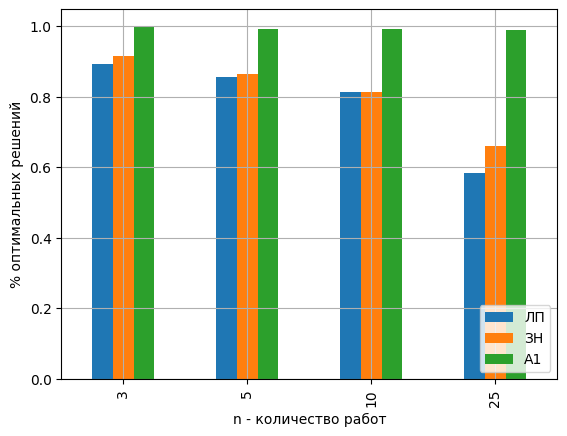


 ['%_lp', '%_lap3', '%_a1'], p = 3


,n,p,np,N,%_lp,%_lap3,%_a1
1,3,3,9,1000,0.092,0.136,0.326
5,5,3,15,1000,0.003,0.013,0.028
9,10,3,30,500,0.000,0.000,0.000


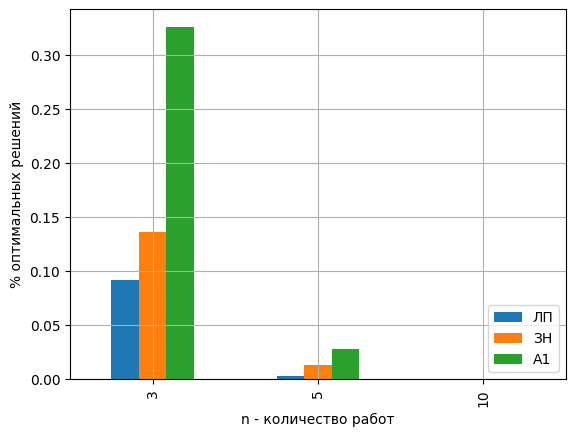


 ['%_lp', '%_lap3', '%_a1'], p = 5


,n,p,np,N,%_lp,%_lap3,%_a1
2,3,5,15,1000,0.0,0.039,0.022
6,5,5,25,500,0.0,0.002,0.000
10,10,5,50,500,0.0,0.000,0.000


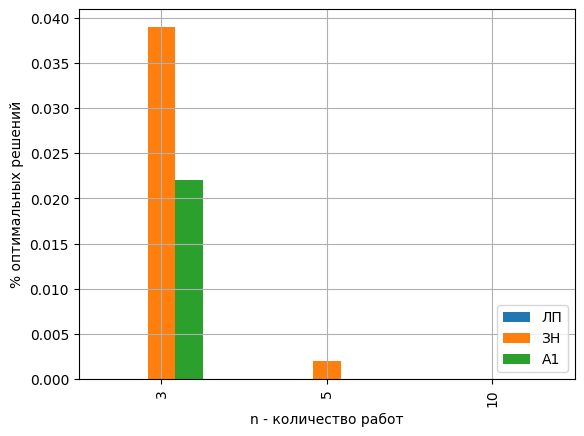


 ['%_lp', '%_lap3', '%_a1'], p = 10


,n,p,np,N,%_lp,%_lap3,%_a1
3,3,10,30,500,0.0,0.02,0.0
7,5,10,50,500,0.0,0.00,0.0


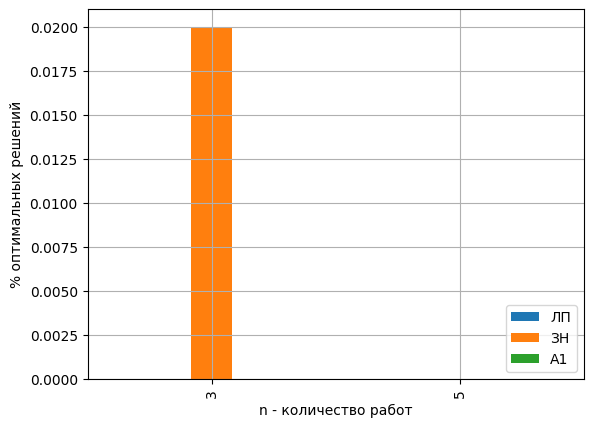

In [43]:
import matplotlib.pyplot as plt

def main():
    df = exec_test_stats_df.copy()
    _bar_columns = ["%_lp", "%_lap3", "%_a1"] # "%_intime", "%_intersec"
    for p in [2, 3, 5, 10]:
        print("\n", f"{str(_bar_columns)}, p = {p}")
        df = exec_test_stats_df.copy()
        df = df[
              (df["np"] < 75)
            & (df["p"] == p)
        ]
        df = df[["n", "p", "np", "N", *_bar_columns]]
        display(df)
        ax = df.plot(
            kind="bar",
            grid=True,
            xlabel="n - количество работ",
            ylabel="% оптимальных решений",
            x="n",
            y=_bar_columns,
        )
        ax.legend(["ЛП", "ЗН", "A1"], loc="lower right")
        plt.show()
main()


 intersection, p = 2


,n,p,np,N,n_intersec,%_intersec
0,3,2,6,1000,622,0.622
4,5,2,10,1000,894,0.894
8,10,2,20,500,499,0.998


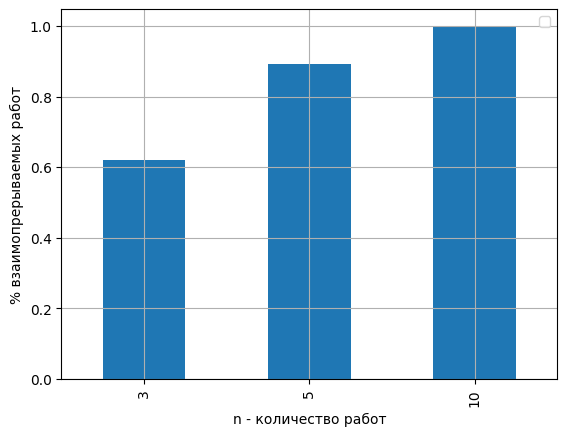


 intersection, p = 3


,n,p,np,N,n_intersec,%_intersec
1,3,3,9,1000,832,0.832
5,5,3,15,1000,971,0.971
9,10,3,30,500,500,1.000


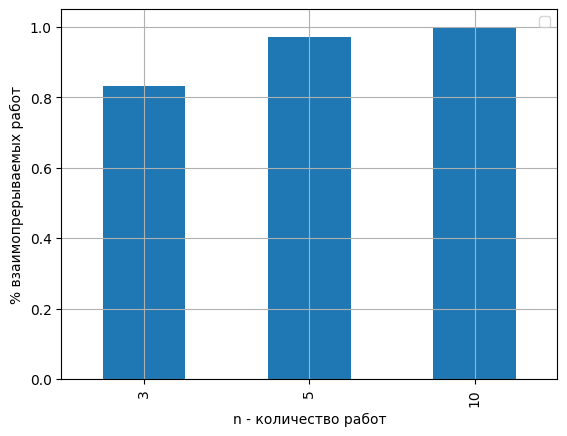


 intersection, p = 5


,n,p,np,N,n_intersec,%_intersec
2,3,5,15,1000,879,0.879
6,5,5,25,500,494,0.988
10,10,5,50,500,500,1.000


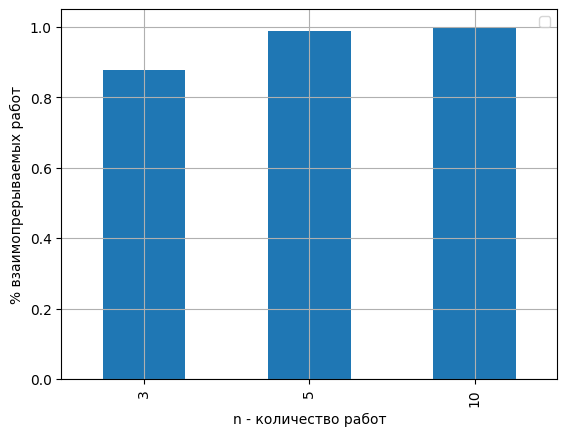


 intersection, p = 10


,n,p,np,N,n_intersec,%_intersec
3,3,10,30,500,470,0.94
7,5,10,50,500,500,1.00
11,10,10,100,50,-50,-1.00


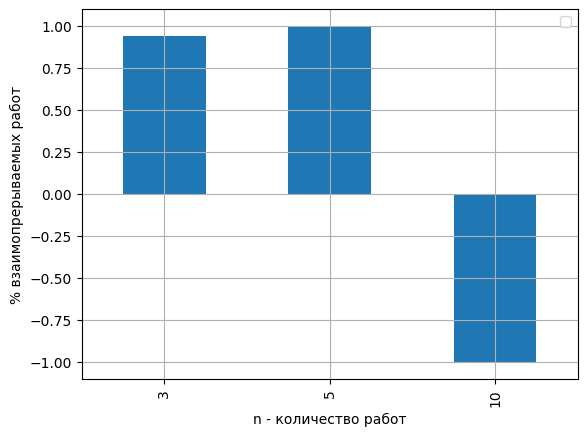

In [44]:
import matplotlib.pyplot as plt

def main():
    df = exec_test_stats_df.copy()
    for p in [2, 3, 5, 10]:
        print("\n", f"intersection, p = {p}")
        df = exec_test_stats_df.copy()
        df = df[
              (df["n"] <= 10)
            & (df["p"] == p)
        ]
        df = df[["n", "p", "np", "N", "n_intersec", "%_intersec"]]
        display(df)
        ax = df.plot(
            kind="bar",
            grid=True,
            x="n",
            y="%_intersec",
            xlabel="n - количество работ",
            ylabel="% взаимопрерываемых работ",
        )
        # ax.legend(loc="lower right")
        ax.legend("")
        plt.show()
main()


 lp_MAPE, n=3


,n,p,np,N,lp_diff,lp_MAPE,lap_diff,lap_MAPE,a1_diff,a1_MAPE
0,3,2,6,976,0.000000,0.000000,0.000000,0.000000,0.127049,0.141534
1,3,3,9,971,8.867149,15.408637,17.265705,27.139337,31.033986,100.715008
2,3,5,15,974,19.521836,20.820073,22.280287,22.711448,118.687885,326.369394
3,3,10,30,495,36.168663,18.357177,36.767677,18.535931,302.951515,355.035303


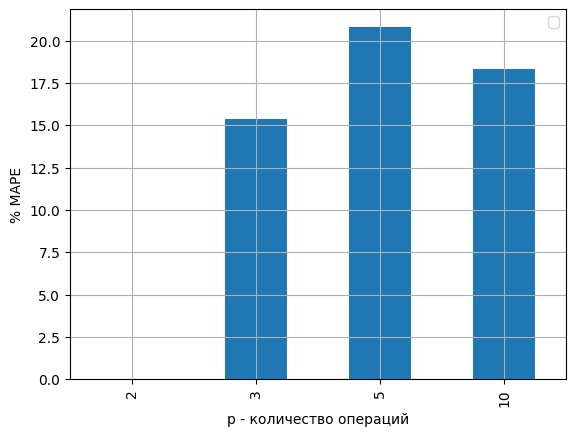


 lp_MAPE, n=5


,n,p,np,N,lp_diff,lp_MAPE,lap_diff,lap_MAPE,a1_diff,a1_MAPE
4,5,2,10,1000,0.000000,0.000000,0.000000,0.000000,0.182000,0.232314
5,5,3,15,992,23.043455,23.979733,42.360887,37.976107,152.604839,287.827753
6,5,5,25,493,33.841688,23.235569,39.077079,24.807547,372.744422,809.465943
7,5,10,50,497,51.263938,19.355290,54.088531,19.894329,879.909457,638.008043


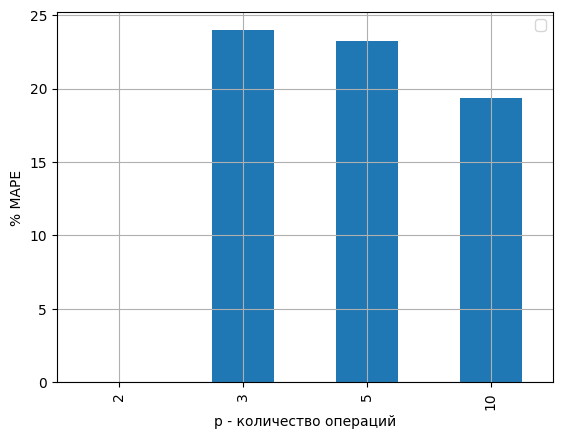


 lap_MAPE, n=3


,n,p,np,N,lp_diff,lp_MAPE,lap_diff,lap_MAPE,a1_diff,a1_MAPE
0,3,2,6,976,0.000000,0.000000,0.000000,0.000000,0.127049,0.141534
1,3,3,9,971,8.867149,15.408637,17.265705,27.139337,31.033986,100.715008
2,3,5,15,974,19.521836,20.820073,22.280287,22.711448,118.687885,326.369394
3,3,10,30,495,36.168663,18.357177,36.767677,18.535931,302.951515,355.035303


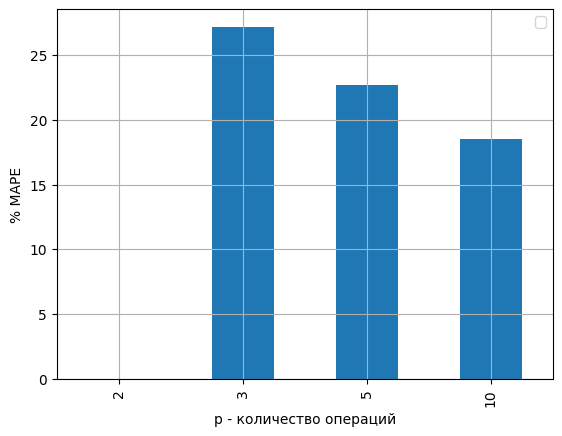


 lap_MAPE, n=5


,n,p,np,N,lp_diff,lp_MAPE,lap_diff,lap_MAPE,a1_diff,a1_MAPE
4,5,2,10,1000,0.000000,0.000000,0.000000,0.000000,0.182000,0.232314
5,5,3,15,992,23.043455,23.979733,42.360887,37.976107,152.604839,287.827753
6,5,5,25,493,33.841688,23.235569,39.077079,24.807547,372.744422,809.465943
7,5,10,50,497,51.263938,19.355290,54.088531,19.894329,879.909457,638.008043


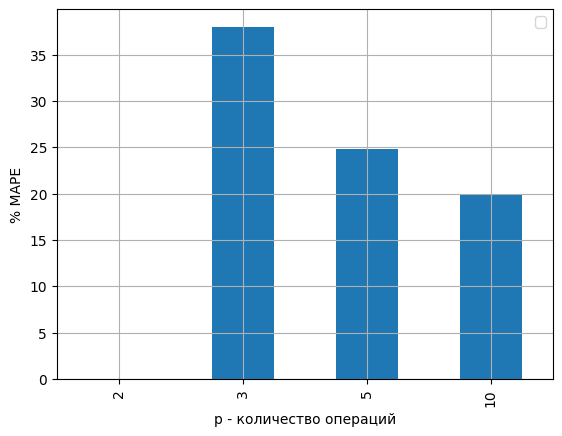


 a1_MAPE, n=3


,n,p,np,N,lp_diff,lp_MAPE,lap_diff,lap_MAPE,a1_diff,a1_MAPE
0,3,2,6,976,0.000000,0.000000,0.000000,0.000000,0.127049,0.141534
1,3,3,9,971,8.867149,15.408637,17.265705,27.139337,31.033986,100.715008
2,3,5,15,974,19.521836,20.820073,22.280287,22.711448,118.687885,326.369394
3,3,10,30,495,36.168663,18.357177,36.767677,18.535931,302.951515,355.035303


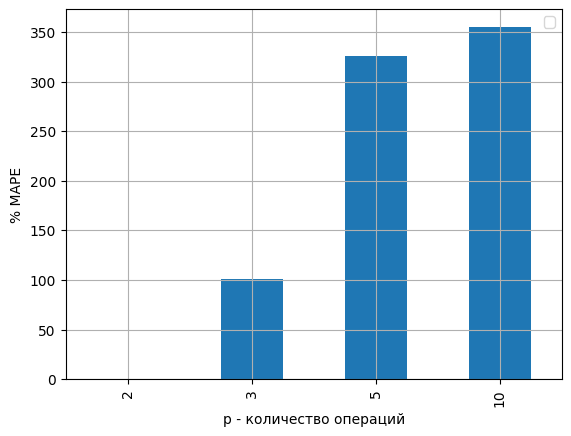


 a1_MAPE, n=5


,n,p,np,N,lp_diff,lp_MAPE,lap_diff,lap_MAPE,a1_diff,a1_MAPE
4,5,2,10,1000,0.000000,0.000000,0.000000,0.000000,0.182000,0.232314
5,5,3,15,992,23.043455,23.979733,42.360887,37.976107,152.604839,287.827753
6,5,5,25,493,33.841688,23.235569,39.077079,24.807547,372.744422,809.465943
7,5,10,50,497,51.263938,19.355290,54.088531,19.894329,879.909457,638.008043


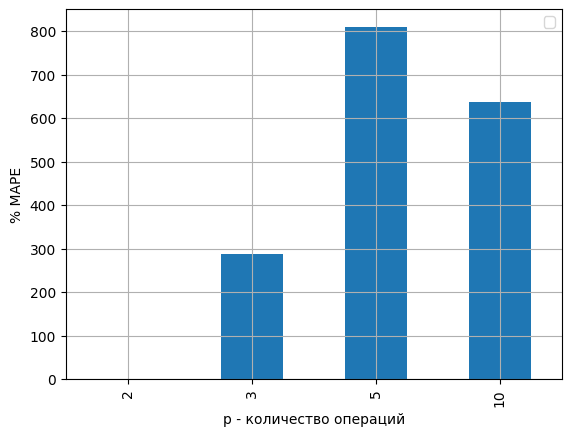

In [45]:
import matplotlib.pyplot as plt

def main():
    for k in ["lp_MAPE", "lap_MAPE", "a1_MAPE"]:
        for n in [3, 5]:
            print("\n", f"{k}, n={n}")
            
            df = exec_test_stats_gap_df.copy()
            df = df[(df["n"] == n)]
            
            display(df)
            
            ax = df.plot(
                kind="bar",
                x="p",
                y=k,
                grid=True,
                xlabel="p - количество операций",
                ylabel="% MAPE",
            )
            ax.legend([])
            # ax.legend(loc="lower right")
            # ax.legend(["ЛП", "ЗН", "A1"], loc="lower right")
            plt.show()
main()